**IMPORTING PACKAGES**

In [1]:
import yfinance as yf

import sys
import pandas as pd
import math
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import xgboost
from xgboost import XGBRegressor

from datetime import datetime
from dateutil.relativedelta import relativedelta

In [3]:
## Check package versions
sklearn.__version__

'0.24.2'

In [4]:
### Downloading Required Data:coffee, wheat, cotton, maize, soya bean
commodities_list = ['coffee', 'wheat', 'cotton', 'corn', 'soybeans']

## Github URL for the commodity prices: All prices are downloaded from https://www.indexmundi.com/commodities/
url = 'https://raw.githubusercontent.com/drakub/wqu/main/'

## Fetching the prices of each commodity
coffee = pd.read_csv(url + 'coffee.csv')
cotton = pd.read_csv(url + 'cotton.csv')
maize  = pd.read_csv(url + 'corn.csv')
wheat  = pd.read_csv(url + 'wheat.csv')
soybean  = pd.read_csv(url + 'soybeans.csv')

In [5]:
## Droping the change column in commodity prices
coffee.drop('Change', inplace = True, axis = 1)
cotton.drop('Change', inplace = True, axis = 1)
maize.drop('Change', inplace = True, axis = 1)
wheat.drop('Change', inplace = True, axis = 1)
soybean.drop('Change', inplace = True, axis = 1)

In [6]:
## Renaming price columns
coffee.rename(columns = {'Price': 'coffee'}, inplace = True)
cotton.rename(columns = {'Price': 'cotton'}, inplace = True)
maize.rename(columns = {'Price': 'maize'}, inplace = True)
wheat.rename(columns = {'Price': 'wheat'}, inplace = True)
soybean.rename(columns = {'Price': 'soybean'}, inplace = True)

In [7]:
## Merging the commodity prices to create one dataframe
prices = (coffee.merge(cotton).merge(maize).merge(wheat).merge(soybean))

In [8]:
prices.head()

,Month,coffee,cotton,maize,wheat,soybean
0,Jul-93,1.09,1.27,101.25,127.50,287.0
1,Aug-93,1.29,1.22,100.31,129.71,274.0
2,Sep-93,1.38,1.22,100.90,131.17,260.0
3,Oct-93,1.30,1.21,106.53,135.95,249.0
4,Nov-93,1.36,1.21,116.67,146.61,267.0


In [9]:
prices.tail()

,Month,coffee,cotton,maize,wheat,soybean
355,Feb-23,2.29,2.19,298.18,394.75,651.12
356,Mar-23,2.35,2.10,282.49,369.86,628.38
357,Apr-23,2.55,2.10,291.11,378.18,614.93
358,May-23,2.70,2.07,268.14,367.74,595.00
359,Jun-23,2.91,2.04,266.87,345.50,591.89


In [10]:
## Formatting the date column
from dateutil.parser import parse
prices['Month'] = prices['Month'].map(lambda d: parse('01 ' + d))

In [11]:
prices.head()

,Month,coffee,cotton,maize,wheat,soybean
0,1993-07-01,1.09,1.27,101.25,127.50,287.0
1,1993-08-01,1.29,1.22,100.31,129.71,274.0
2,1993-09-01,1.38,1.22,100.90,131.17,260.0
3,1993-10-01,1.30,1.21,106.53,135.95,249.0
4,1993-11-01,1.36,1.21,116.67,146.61,267.0


In [12]:
## Changing the date column
prices.rename(columns = {'Month':'Date'}, inplace=True)

In [13]:
prices.head()

,Date,coffee,cotton,maize,wheat,soybean
0,1993-07-01,1.09,1.27,101.25,127.50,287.0
1,1993-08-01,1.29,1.22,100.31,129.71,274.0
2,1993-09-01,1.38,1.22,100.90,131.17,260.0
3,1993-10-01,1.30,1.21,106.53,135.95,249.0
4,1993-11-01,1.36,1.21,116.67,146.61,267.0


**Data Analysis and Visualization**

In [14]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 0 to 359
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     360 non-null    datetime64[ns]
 1   coffee   360 non-null    float64       
 2   cotton   360 non-null    float64       
 3   maize    360 non-null    float64       
 4   wheat    360 non-null    float64       
 5   soybean  360 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 19.7 KB


In [15]:
prices.describe()

,coffee,cotton,maize,wheat,soybean
count,360.000000,360.000000,360.000000,360.000000,360.000000
mean,1.750000,1.717833,165.334333,213.768861,376.596333
std,0.622977,0.570195,69.512643,83.809473,137.630709
min,0.500000,0.820000,75.270000,102.160000,183.000000
25%,1.390000,1.317500,106.892500,150.247500,260.000000
50%,1.770000,1.655000,157.170000,192.520000,368.975000
75%,2.172500,1.930000,191.555000,269.197500,469.130000
max,4.030000,5.060000,348.170000,522.290000,737.060000


In [16]:
## Convert the date column into datetime and make it index column
prices['Date'] = pd.to_datetime(prices['Date'])
prices.set_index('Date', inplace=True)

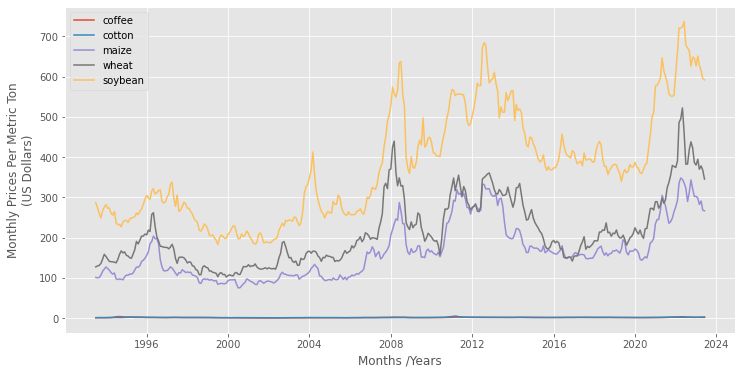

In [71]:
## Visualize the commodity prices
commodities = [commodity for commodity in prices.columns if prices[commodity].dtypes != 'O']

style.use('ggplot')
plt.figure(figsize=(12, 6))
plt.plot(prices)
plt.xlabel('Months /Years')
plt.ylabel('Monthly Prices Per Metric Ton\n(US Dollars)')
plt.legend(commodities)
plt.show()

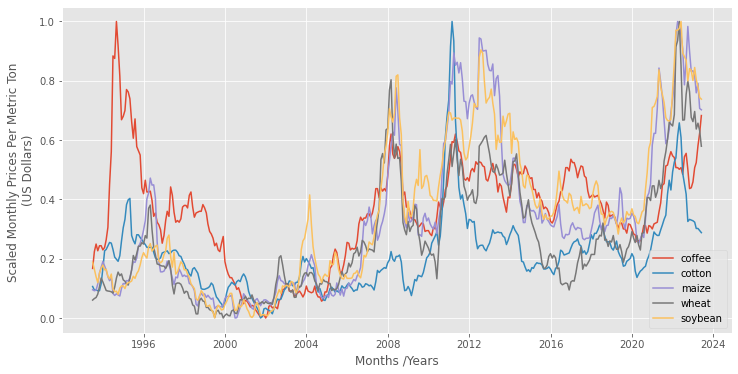

In [73]:
## Visualized scaled prices
min_max_scaled_prices = prices.copy()
for column in prices:
    num_ = (min_max_scaled_prices[column] - min_max_scaled_prices[column].min())
    den_ = (min_max_scaled_prices[column].max() - min_max_scaled_prices[column].min())

    min_max_scaled_prices[column] = num_/den_

plt.figure(figsize=(12, 6))
plt.plot(min_max_scaled_prices)
plt.xlabel('Months /Years')
plt.ylabel('Scaled Monthly Prices Per Metric Ton \n(US Dollars)')
plt.legend(commodities)
plt.show()

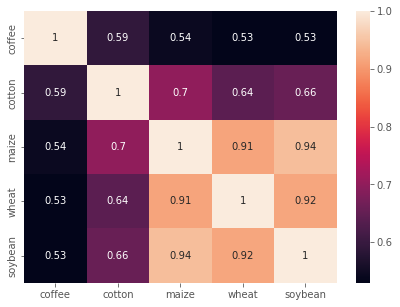

In [19]:
## Visualizing the Correlation among the commodity prices
corMatrix = prices.corr()
fig = plt.figure(figsize=(7, 5))
sns.heatmap(corMatrix, annot = True)
plt.show()

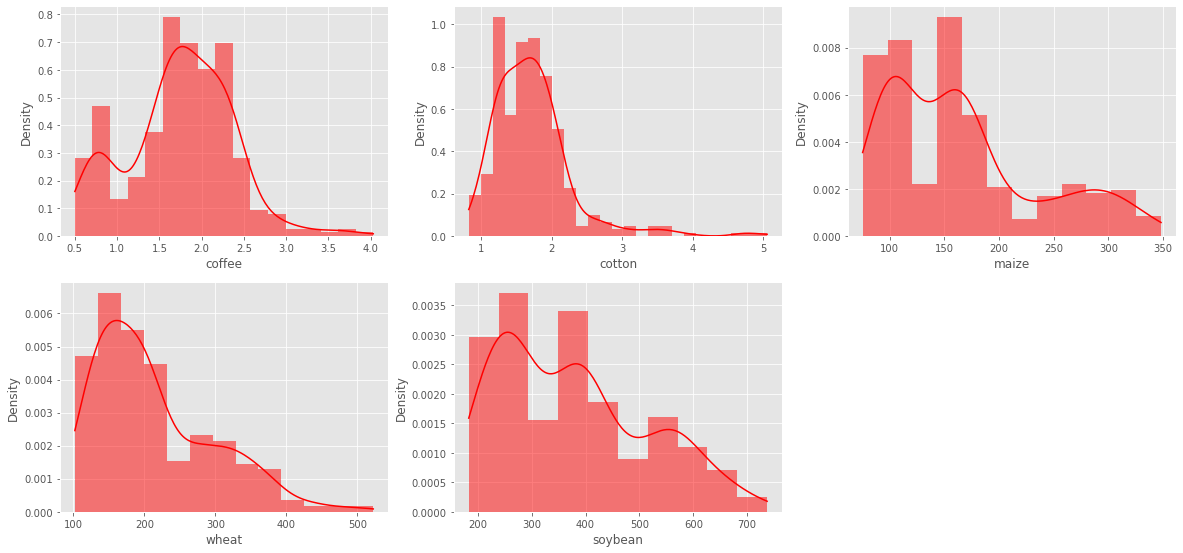

In [20]:
## Generating Time Series
plt.figure(figsize=(20, 60))
plotnumber = 1
for feature in commodities:
    ax = plt.subplot(12, 3, plotnumber)
    sns.histplot(prices[feature], color = "red", kde = True, stat = "density", linewidth = 0)
    plotnumber+=1
plt.show()

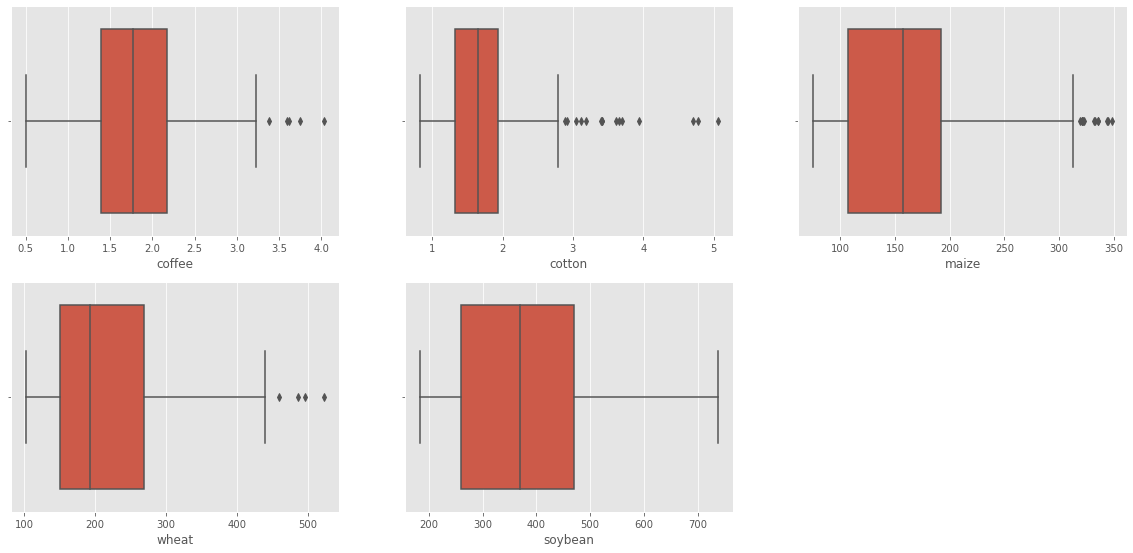

In [21]:
## Box plots
plt.figure(figsize=(20, 60))
plotnumber = 1
for feature in commodities:
    ax = plt.subplot(12, 3, plotnumber)
    sns.boxplot(x = prices[feature])
    plt.xlabel(feature)
    plotnumber+=1
plt.show()

**TRAINING ALGORITHM AND PREDICTING PRICES**

In [37]:
def findModelUsingGridSearchCv(x, y):
    algos = {
        'DecisionTreeRegressor': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        },
        'RandomForestRegressor': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [10, 50, 100, 130],
                'criterion': ['mse'],
                'max_depth': range(2, 4, 1),
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {
                'objective': ['reg:squarederror'],
                'learning_rate': [0.5, 0.1, 0.01, 0.001],
                'max_depth': [2, 3],
                'n_estimators': [10, 50, 100, 200]
            }
        },
        'LinearRegression': {
            'model': LinearRegression(),
            'params': {}
        }

    }
    scores = []
    cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'],cv = cv, return_train_score = False)
        gs.fit(x,y)
        scores.append({
            'model':algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])

In [31]:
def plotCorrGraph(commodity):
    plt.figure(figsize=(20, 60))
    plotnumber = 1
    for item in commodities:
        ax = plt.subplot(12, 3, plotnumber)
        plt.scatter(prices[item], prices[commodity])
        plt.xlabel(item)
        plt.ylabel(commodity)
        plotnumber += 1
    plt.show()

In [32]:
def spitDataSet(target):
    y = prices[target]
    X = prices.drop([target],axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=0)
    return X, y

In [74]:
def plotOriginalPredictedPrices(predicted, original, target):
    fig = plt.figure(figsize=(12, 6))
    plt.plot(predicted, color="red", label="Predicted Price")
    plt.plot(list(original),color="green", label="Original Price")
    plt.title(target)
    plt.xlabel('No. of values')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

### 1. Predicting Coffee Prices

coffee     1.000000
cotton     0.590882
maize      0.544259
wheat      0.529747
soybean    0.530519
Name: coffee, dtype: float64


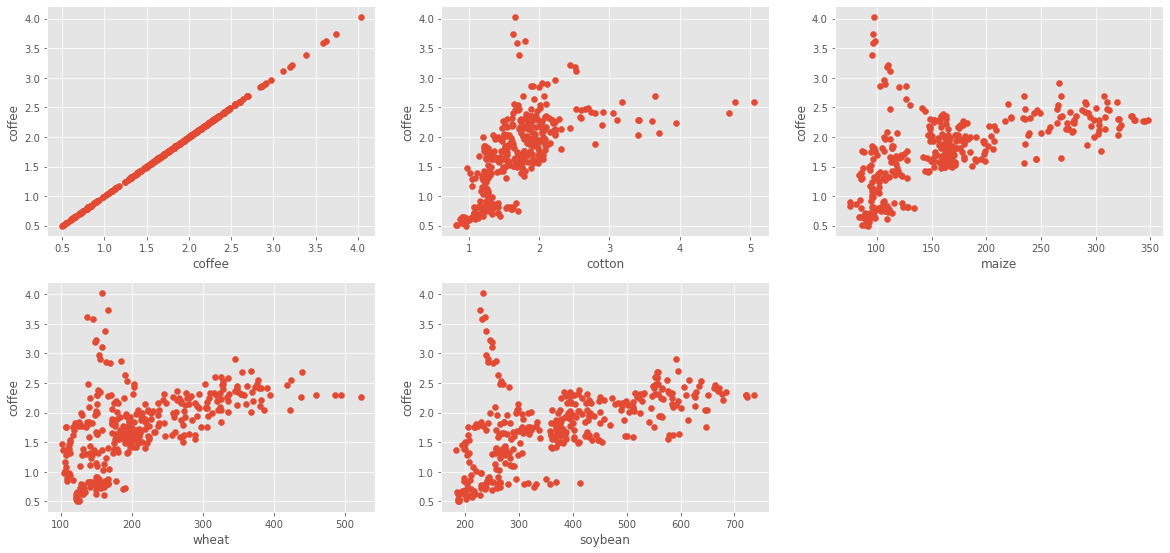

In [34]:
## Print the correlation matrix for coffee
print(corMatrix['coffee'])

## Visualize the correlation between coffee prices and other commodity prices
plotCorrGraph('coffee')

In [35]:
## Find the best model for Coffee Price Prediction
split = spitDataSet('coffee')
X = split[0]
y = split[1]

In [38]:
pd.set_option('display.max_colwidth', 100)
findModelUsingGridSearchCv(X,y)

,model,best_score,best_params
0,DecisionTreeRegressor,0.675677,"{'criterion': 'mse', 'splitter': 'random'}"
1,RandomForestRegressor,0.719795,"{'criterion': 'mse', 'max_depth': 3, 'n_estimators': 130}"
2,XGBRegressor,0.755597,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'objective': 'reg:squarederror'}"
3,LinearRegression,0.300605,{}


Since the best model is XGBRegressor performing with an accuracy score of 75.56% using Squared Error measure, we shall predict coffee prices using this algorithm

In [44]:
## Predicting coffee prices using XGBRegressor Algorithm Model
y = prices['coffee']
X = prices.drop(['coffee'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=0)

xgb_model = XGBRegressor(learning_rate = 0.1, max_depth = 3, 
                   n_estimators = 200, 
                   objective = 'reg:squarederror')
xgb_model.fit(X_train, y_train)


confidence = xgb_model.score(X_test, y_test)
confidence

0.683761765390827

In [52]:
y_pred = xgb_model.predict(X_test)
y_pred

array([1.310802  , 2.1383488 , 0.5669039 , 2.177568  , 0.8303438 ,
       0.9262919 , 2.4567542 , 1.2851804 , 1.7367033 , 1.2080114 ,
       2.418499  , 2.1095617 , 1.957604  , 2.2245917 , 1.293136  ,
       2.0026703 , 0.80718786, 1.47983   , 1.1750518 , 1.9381753 ,
       2.0026703 , 1.9821372 , 1.5857911 , 1.1505803 , 2.14491   ,
       1.6689738 , 1.2871467 , 1.2779526 , 2.1052425 , 0.5669039 ,
       1.8251238 , 1.8616456 , 1.6092145 , 0.988551  , 1.4162233 ,
       0.9429987 , 1.45471   , 2.0833006 , 2.2325277 , 0.95286256,
       3.0426693 , 1.9259926 , 1.8655136 , 1.8513932 , 2.5124602 ,
       1.8591365 , 1.8754345 , 1.1592155 , 1.3002062 , 1.6826342 ,
       1.9940902 , 1.1400366 , 2.3121006 , 2.340062  , 1.9135077 ,
       0.9905766 , 2.340062  , 1.676918  , 1.4933972 , 2.3008096 ,
       1.3796171 , 0.5669039 , 0.8478783 , 1.5532985 , 1.9506762 ,
       1.0683577 , 2.183124  , 2.2583332 , 1.6419168 , 1.8082023 ,
       1.0435965 , 1.4829732 ], dtype=float32)

In [53]:
y_test

Date
1994-01-01    1.31
2012-02-01    2.25
2002-05-01    0.62
2011-07-01    2.49
2001-01-01    0.71
              ... 
2007-12-01    2.01
2019-12-01    1.61
2010-02-01    1.50
1998-10-01    1.77
2003-11-01    0.75
Name: coffee, Length: 72, dtype: float64

In [54]:
error_score = metrics.r2_score(y_test,y_pred)
print("R squared:",error_score)

R squared: 0.683761765390827


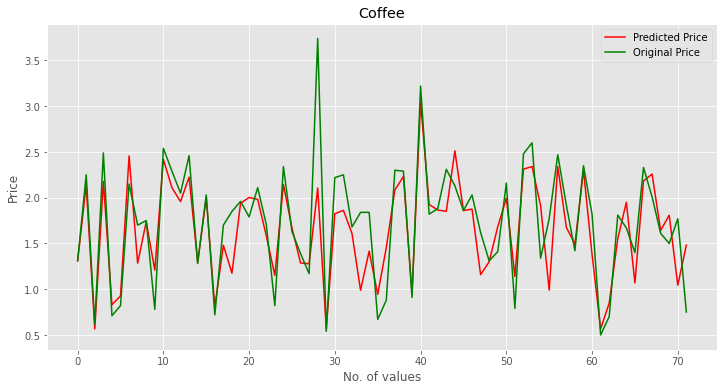

In [75]:
plotOriginalPredictedPrices(y_pred, y_test, 'Coffee')

### 2. Predicting Cotton Prices

coffee     0.590882
cotton     1.000000
maize      0.699266
wheat      0.640590
soybean    0.655467
Name: cotton, dtype: float64


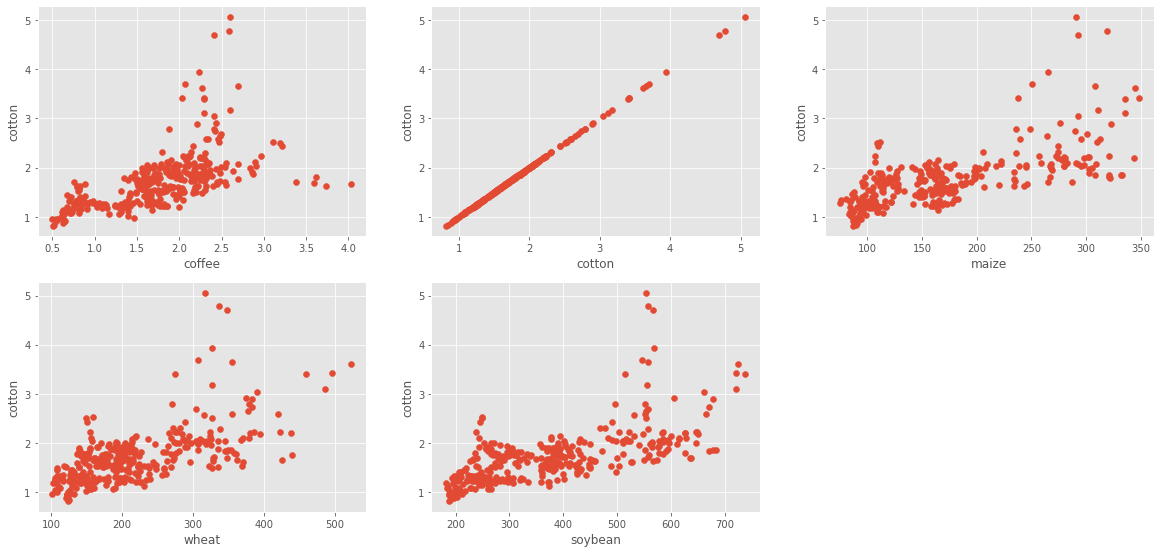

In [76]:
## Print the correlation matrix for coffee
print(corMatrix['cotton'])

## Visualize the correlation between coffee prices and other commodity prices
plotCorrGraph('cotton')

In [78]:
## Find the best model for Cotton Price Prediction
split = spitDataSet('cotton')
X = split[0]
y = split[1]

pd.set_option('display.max_colwidth', 100)
findModelUsingGridSearchCv(X,y)

,model,best_score,best_params
0,DecisionTreeRegressor,0.459166,"{'criterion': 'friedman_mse', 'splitter': 'best'}"
1,RandomForestRegressor,0.599398,"{'criterion': 'mse', 'max_depth': 3, 'n_estimators': 10}"
2,XGBRegressor,0.616186,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror'}"
3,LinearRegression,0.504627,{}


In [79]:
## Predicting Cotton prices using XGBRegressor Algorithm Model
y = prices['cotton']
X = prices.drop(['cotton'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=0)

xgb_model = XGBRegressor(learning_rate = 0.1, max_depth = 3, 
                   n_estimators = 200, 
                   objective = 'reg:squarederror')
xgb_model.fit(X_train, y_train)


confidence = xgb_model.score(X_test, y_test)
confidence

0.5299691144988334

In [80]:
y_pred = xgb_model.predict(X_test)
y_pred

array([1.4517158 , 1.9558345 , 0.97231525, 3.173799  , 1.2129173 ,
       1.2876749 , 1.9683175 , 1.346625  , 1.5310093 , 1.2194377 ,
       1.83021   , 2.1907535 , 1.681909  , 2.1769867 , 1.3993413 ,
       2.2346647 , 1.194485  , 1.447681  , 1.3237507 , 1.8368672 ,
       1.8739411 , 1.957691  , 1.6872784 , 1.2737012 , 1.8210523 ,
       1.548691  , 1.1814225 , 1.1994481 , 1.6654317 , 0.9293842 ,
       1.6068964 , 1.8326999 , 1.6632061 , 1.6698875 , 1.6698875 ,
       1.2833502 , 1.5470301 , 1.8741181 , 1.8212308 , 1.2876749 ,
       2.413795  , 1.4779022 , 1.7477009 , 1.675213  , 2.1757326 ,
       1.9322935 , 1.5381334 , 1.2767845 , 1.2621682 , 1.5712823 ,
       1.5432343 , 1.325251  , 1.7191696 , 4.8748574 , 1.4118096 ,
       1.3541312 , 3.5202694 , 1.7913188 , 1.5029026 , 2.564534  ,
       1.3611621 , 0.91384625, 1.236985  , 1.6337581 , 1.4430481 ,
       1.3167372 , 1.9103049 , 1.4988315 , 1.6189808 , 1.8641471 ,
       1.3169245 , 1.486703  ], dtype=float32)

In [81]:
y_test

Date
1994-01-01    1.53
2012-02-01    2.22
2002-05-01    0.88
2011-07-01    2.69
2001-01-01    1.41
              ... 
2007-12-01    1.53
2019-12-01    1.67
2010-02-01    1.76
1998-10-01    1.36
2003-11-01    1.70
Name: cotton, Length: 72, dtype: float64

In [82]:
error_score = metrics.r2_score(y_test,y_pred)
print("R squared:",error_score)

R squared: 0.5299691144988334


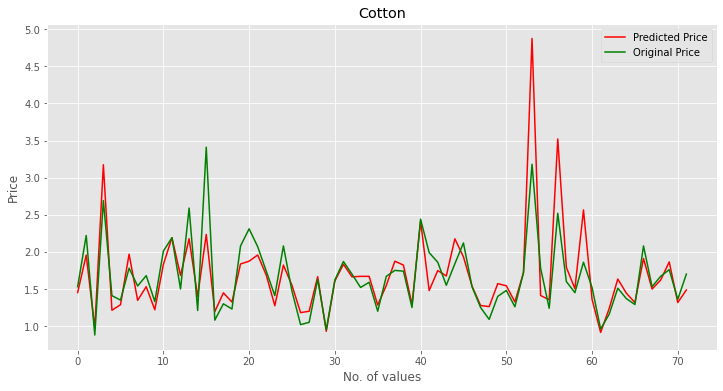

In [84]:
plotOriginalPredictedPrices(y_pred, y_test, 'Cotton')